In [2]:
function shannonentropy{T}(V::AbstractVector{T})
    H = zero(T)
    for i=1:length(V)
        V[i]==0 && continue
        H -= V[i]*log2(V[i])
    end
    H
end    

shannonentropy (generic function with 1 method)

In [3]:
function symKL{T}(p::AbstractMatrix{T}, q::AbstractMatrix{T})
    C = zero(T)
    m, n = size(p)
    @assert (m, n) == size(q)
    for i=1:m, j=1:n
        i==j && continue
        p[i,j]==0 && continue
        q[i,j]==0 && continue
        C += p[i,j] * log(p[i,j]/q[i,j])
    end
    C
end

symKL (generic function with 1 method)

In [4]:
#Jacobs' learning rate updating rule
function learnupdate(ϵ, δ, δ̄ , θ=0.2, ϕ=0.5, κ=0.5)
    test = δ̄ *δ
    δ̄ = (1-θ)*δ + θ*δ̄ 
    Δϵ = if test > 0
            κ
        elseif test < 0
            -ϕ*ϵ
        else
            0.0
        end
    Δϵ, δ̄ 
end

learnupdate (generic function with 4 methods)

In [5]:
function tsne{S<:Real}(X::Matrix{S}, σ::Vector{S}, k::Int=2,
        T::Int=1000, η=100)
    
    m, n = size(X)
    @assert length(σ) == n
    #Compute pairwise affinities
    p = zeros(S, n, n)
    psum = zero(S)
    for i=1:n, j=1:n
        thisp = exp(-norm(slice(X, :, i) - slice(X, :, j))^2/(2σ[i]^2))
        p[j, i] = thisp
        psum += thisp
    end
    scale!(p, 1/psum)

    #Compute Shannon entropy
    for i=1:n
        H = shannonentropy(slice(p, :, i))
        info("Entropy_i = $H, perplexity = $(2^H) (5--50 recommended)")
    end
    #Symmetrize
    p = (p + p')/(2n)
    #Sample initial solution
    Y = randn(k, n)*1e-4
    Y₋= zeros(k, n)
    δ̄ = zeros(k, n) #Used for weighted update
    ηs= fill(float(η), k, n)
    for t=1:T
        #Compute low-dimensional affinities
        q = zeros(n, n)
        qsum = 0.0
        for i=1:n, j=1:n
            δy = slice(Y, :, i) - slice(Y, :, j)
            thisq = 1/(1 + δy⋅δy)
            q[i,j] = thisq
            i==j || (qsum += thisq)
        end
        scale!(q, 1/qsum)
        #Compute δC_δy
        δC_δy = zeros(k, n)
        exag = t<50 ? 4.0 : 1.0 #"early exaggeration" 
        for i=1:n, j=1:n
            δC_δy[:, i] += 4*(exag*p[i,j] - q[i,j])*
            (Y[:, i] - Y[:, j])/
            (1 + norm(slice(Y, :, i) - slice(Y, :, j))^2)
        end
        α = t<250 ? 0.5 : 0.8
        #Update Y
        Y, Y₋ = Y + η.*δC_δy + α*(Y-Y₋), Y
        #Update η (Jacobs, 1988)
        for i=1:n, j=1:k
            Δϵ, δ̄ [j, i] = learnupdate(ηs[j, i], δC_δy[j, i], δ̄ [j, i])
            ηs[j, i] += Δϵ
        end
        #Print cost function
        cost = symKL(p, q)
        info("Iteration $t: cost = $cost") 
    end
    Y
end

tsne (generic function with 4 methods)

In [6]:
#Do t-SNE with quasi-Newton

In [7]:
function backtracklinesearch(p, x, f, df_dx, α=1.0, c=0.5, τ=0.5, maxiter::Int=10)
    m = p⋅df_dx
    t = -c*m
    for j = 1:maxiter
        f(x) - f(x+α*p) ≥ α*t && break 
        α *= τ
    end
    α
end

backtracklinesearch (generic function with 5 methods)

In [8]:
function compute_dC_dq(Y, p, q)
    k, n = size(Y)
    δC_δy = zeros(k, n)
    for i=1:n, j=1:n
        δC_δy[:, i] += 4*(p[i,j] - q[i,j])*
        (Y[:, i] - Y[:, j])/
        (1 + norm(slice(Y, :, i) - slice(Y, :, j))^2)
    end
    δC_δy
end

compute_dC_dq (generic function with 1 method)

In [9]:
function computeq(Y)
    n = size(Y, 2)
    q = zeros(n, n)
    qsum = 0.0
    for i=1:n, j=1:n
        δy = slice(Y, :, i) - slice(Y, :, j)
        thisq = 1/(1 + δy⋅δy)
        q[i,j] = thisq
        i==j || (qsum += thisq)
    end
    scale!(q, 1/qsum)
end

computeq (generic function with 1 method)

In [10]:
function tsne_bfgs{S<:Real}(X::Matrix{S}, σ::Vector{S}, k::Int=2,
        T::Int=1000, η=100)
    
    m, n = size(X)
    @assert length(σ) == n
    #Compute pairwise affinities
    p = zeros(S, n, n)
    psum = zero(S)
    for i=1:n, j=1:n
        thisp = exp(-norm(slice(X, :, i) - slice(X, :, j))^2/(2σ[i]^2))
        p[j, i] = thisp
        psum += thisp
    end
    scale!(p, 1/psum)

    #Compute Shannon entropy
#     for i=1:n
#         H = shannonentropy(slice(p, :, i))
#         info("Entropy_i = $H, perplexity = $(2^H) (5--50 recommended)")
#     end
    #Symmetrize
    p = (p + p')/(2n)

    #Sample initial solution
    Y = randn(k, n)*1e-4
    Y₋= zeros(k, n)
    δ̄ = zeros(k, n) #Used for weighted update
    ηs= fill(float(η), k, n)
    
    #Initialize pseudo-Hessian
    B = eye(k*n)
    cost = Inf
    for t=1:T
        #Compute low-dimensional affinities
        q = computeq(Y)
        #Compute δC_δy
        δC_δy = compute_dC_dq(Y, p, q)

        #Search direction
        px = -B\δC_δy[:]
        
        #Backtracking line search
        α = backtracklinesearch(px, Y[:], y->symKL(p, computeq(reshape(y,k,n))), δC_δy[:])
        
        sx = α*px
        Y=Y+reshape(sx, k, n)
        yx = compute_dC_dq(Y, p, computeq(Y))[:] - δC_δy[:]
        
        tx = B*sx
        B = B + yx*yx'/(yx⋅sx) - tx*tx'/(sx⋅tx)

        #Print cost function
        cost, oldcost = symKL(p, q), cost
        info("Iteration $t: cost = $cost")
        abs(cost - oldcost) < 1e-9 && break
    end
    Y
end

tsne_bfgs (generic function with 4 methods)

In [15]:
X, Y = randn(100,100), randn(100)
@time Y1 = tsne(X, Y)
@time Y2 = tsne_bfgs(X, Y)

INFO: Entropy_i = 0.0664384601286977, perplexity = 1.0471284741854807 (5--50 recommended)
INFO: Entropy_i = 0.06643846012869781, perplexity = 1.047128474185481 (5--50 recommended)
INFO: Entropy_i = 0.0664384601286977, perplexity = 1.0471284741854807 (5--50 recommended)
INFO: Entropy_i = 0.0664384601291844, perplexity = 1.047128474185834 (5--50 recommended)
INFO: Entropy_i = 0.0664384601286977, perplexity = 1.0471284741854807 (5--50 recommended)
INFO: Entropy_i = 0.0664384601286977, perplexity = 1.0471284741854807 (5--50 recommended)
INFO: Entropy_i = 0.0664384601286977, perplexity = 1.0471284741854807 (5--50 recommended)
INFO: Entropy_i = 0.0664384601286977, perplexity = 1.0471284741854807 (5--50 recommended)
INFO: Entropy_i = 0.06643846013106851, perplexity = 1.0471284741872016 (5--50 recommended)
INFO: Entropy_i = 0.0664384601286977, perplexity = 1.0471284741854807 (5--50 recommended)
INFO: Entropy_i = 0.0664384601286977, perplexity = 1.0471284741854807 (5--50 recommended)
INFO: Entr

elapsed time: 220

INFO: Iteration 1: cost = -2.6137312632195783e-7


.986708805 seconds (35170424256 bytes allocated, 30.08% gc time)


INFO: Iteration 2: cost = -2.6137312632194995e-7


elapsed time: 2.711339183 seconds (483205024 bytes allocated, 31.61% gc time)


2x100 Array{Float64,2}:
 5.1166e-6  5.1166e-6  5.11658e-6  …  5.11657e-6  5.11655e-6  5.11657e-6
 2.6701e-7  2.67e-7    2.67003e-7     2.67041e-7  2.67e-7     2.66982e-7

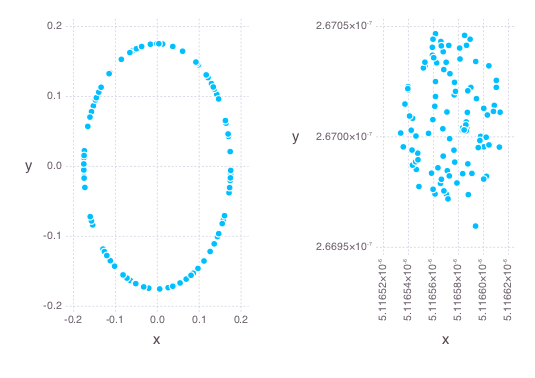

In [16]:
using Gadfly
hstack(plot(x=Y1[1,:], y=Y1[2,:]), plot(x=Y2[1,:], y=Y2[2,:]))